In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import scipy.stats as sps
import scipy.sparse as sparse
from sklearn.model_selection import train_test_split
from time import time_ns
import sympy

from umap.umap_ import UMAP
from umap import umap_
from MulticoreTSNE import MulticoreTSNE
from sklearn.manifold import TSNE

from warnings import filterwarnings
filterwarnings('ignore')

import seaborn as sns
sns.set(font_scale=1.5)

Внимание!!!   
Не спользуйте UMAP версии 0.4.0rc1. Лучше используйте 0.3.10.

## `UMAP`
[Главная страница проекта](https://umap-learn.readthedocs.io/en/latest/).  
[Статья от авторов](https://arxiv.org/abs/1802.03426).  
[Визуализация](https://pair-code.github.io/understanding-umap/).  

`UMAP(n_neighbors=15, n_components=2, metric='euclidean', n_epochs=None, learning_rate=1.0, init='spectral', min_dist=0.1, spread=1.0, set_op_mix_ratio=1.0, local_connectivity=1.0, repulsion_strength=1.0, negative_sample_rate=5, transform_queue_size=4.0, a=None, b=None, random_state=None, metric_kwds=None, angular_rp_forest=False, target_n_neighbors=-1, target_metric='categorical', target_metric_kwds=None, target_weight=0.5, transform_seed=42, verbose=False)`

**Гиперпараметры** 
* `n_neighbors` &mdash; количество соседей, используемое при подсчете локальной метрики. Определяет глобальность многообразий, определяемых методом. При очень маленьких значениях параметра, UMAP концентрируется только на локальных структурах. И, наоборот, при слишком больших значениях, метод изучает глобальную структуру, и практически игнорирует локальные отличия. 
* `min_dist` &mdash; минимальное расстояние между точками в новом представлении. Чем меньше значение этого параметра, тем больше новое представление будет похоже на комочки точек. При больших значениях распределение точкек в пространстве будут больше походить на равномерное распределение. 
* `n_components` &mdash; размерность нового представления.
* `metric` &mdash; метрика входных данных. Поддерживаются следующие метрики: метрики на подобие метрики Минковского &mdash; `euclidean`, `manhattan`, `chebyshev`, `minkowski`; нормированные пространственные метрики &mdash; `mahalanobis`, `wminkowski`, `seuclidean`; другие пространственные метрики &mdash; `canberra`, `braycurtis`, `haversine`; угловые и корреляционные метрики &mdash; `cosine`, `correlation`; а также метрики для бинарных данных &mdash; `hamming`, `jaccard`, `dice`, `russellrao`, `kulsinski`, `rogerstanimoto`, `sokalmichener`, `sokalsneath`, `yule`.  
...  

**Методы**
* `fit(X, y=None)` &mdash; обучиться на данных `X`, можно указать `y` для использования метода снижения размерности с учителем.  
* `fit_transform(X, y=None)` &mdash; обучиться на данных `X` и вернуть сжатое представление `X`, можно указать `y` для использования метода снижения размерности с учителем.  
* `transform(X_new)` &mdash; вернуть сжатое представление `X_new` для обученной ранее модели.  
* `inverse_transform(Y)` &mdash; восстановить сжатые данные `Y` в исходное пространство. *Пока не поддерживается.*

## `MulticoreTSNE`  &mdash; ускоренная версия TSNE
[Главная страница проекта](https://github.com/DmitryUlyanov/Multicore-TSNE).  

`MulticoreTSNE(n_components=2, perplexity=30.0, early_exaggeration=12, learning_rate=200, n_iter=1000, n_iter_early_exag=250, n_iter_without_progress=30, min_grad_norm=1e-07, metric='euclidean', init='random', verbose=0, random_state=None, method='barnes_hut', angle=0.5, n_jobs=1, cheat_metric=True,)`

**Гиперпараметры**  
* `n_components` &mdash; размерность сжатого пространства
* `perplexity` &mdash; связано с количеством соседей для оценки многообразия.  

**Методы**
* `fit(X)` &mdash; обучиться на данных `X`.
* `fit_transform(X, y=None)` &mdash; обучиться на данных `X` и вернуть сжатое представление `X`.

## Сравенение `UMAP` и `MulticoreTSNE`

Датасет &mdash; точки, координаты которых в первых двух измерениях представляют собой три нормально распределенных кластера, в остальных 8 измерениях координаты не образуют кластеров и распределены нормально.

In [2]:
# Генерация данных
n_samples = 500
X = np.zeros((n_samples, 10))

X[:, :2], y = make_blobs(
    n_samples=n_samples, n_features=2, 
    # параметры 3 кластеров
    centers=[[0, 0], [2, -0.5], [1.5, 3]],
    cluster_std=[0.5, 0.5, 0.5],
)

X[:, 2:] = sps.norm(0, 0.2).rvs((n_samples, 8))

Посмотрим на данные. На данном этапе цвет точек не имеет значение. Он пригодится в дальнейшем для сравнения этих графиков с графиком точек в сжатом пространстве.

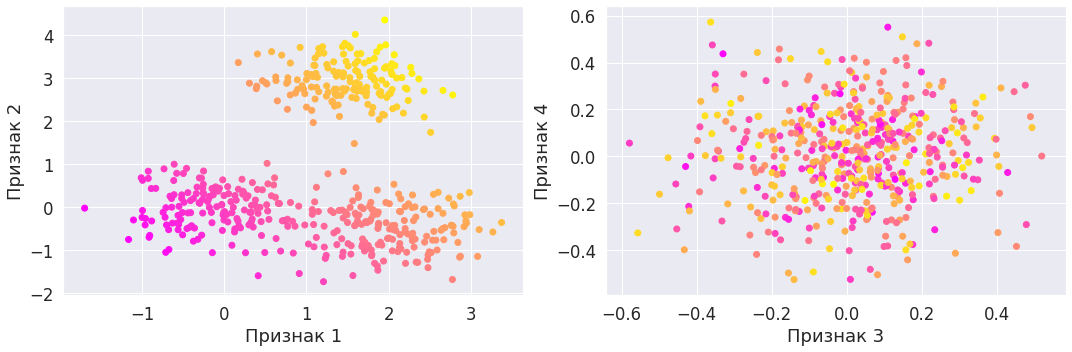

In [3]:
colors = 3*X.T[0] + 2*X.T[1]

plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=colors, cmap='spring')
plt.xlabel('Признак 1')
plt.ylabel('Признак 2')
plt.subplot(122)
plt.scatter(X[:, 2], X[:, 3], c=colors, cmap='spring')
plt.xlabel('Признак 3')
plt.ylabel('Признак 4')
plt.tight_layout()

Сравнение времени работы MulticoreTSNE, UMAP и реализации t-SNE из sklearn.

In [4]:
%timeit MulticoreTSNE(n_components=2).fit_transform(X)

1.95 s ± 62.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
%timeit UMAP(n_components=2).fit_transform(X)

708 ms ± 4.47 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
%timeit TSNE(n_components=2).fit_transform(X)

2.27 s ± 54.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Применяем методы для визуализации

In [7]:
X_tsne = MulticoreTSNE(n_components=2).fit_transform(X)
X_umap = UMAP(n_components=2).fit_transform(X)

Визуализация результатов

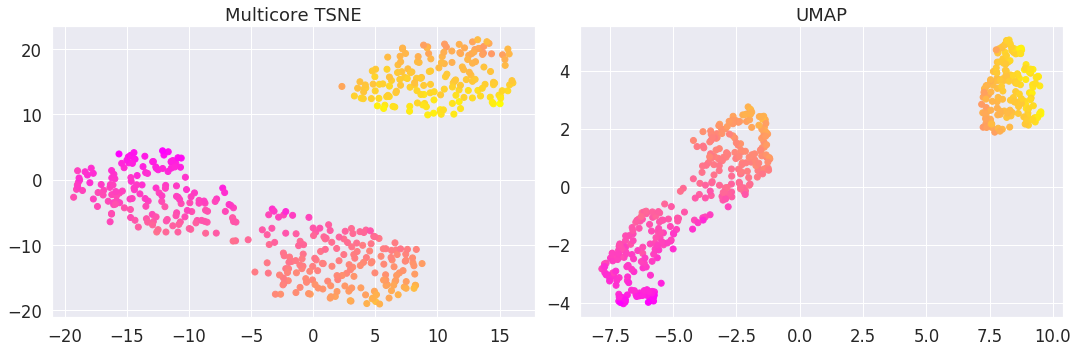

In [8]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=colors, cmap='spring')
plt.title('Multicore TSNE')
plt.subplot(122)
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=colors, cmap='spring')
plt.title('UMAP')
plt.tight_layout()

## UMAP train & test
UMAP в отличие от TSNE позволяет обучаться на части данных, и получать новое представление для другой части данных, не используемых при обучении.

Сделаем разбиение данных на train и test и обучим UMAP на обучающей выборке

In [9]:
X_train, X_test, colors_train, colors_test = train_test_split(
    X, colors, test_size=0.2)

model = UMAP(n_components=2).fit(X_train)
X_umap_train = model.transform(X_train)
X_umap_test = model.transform(X_test)

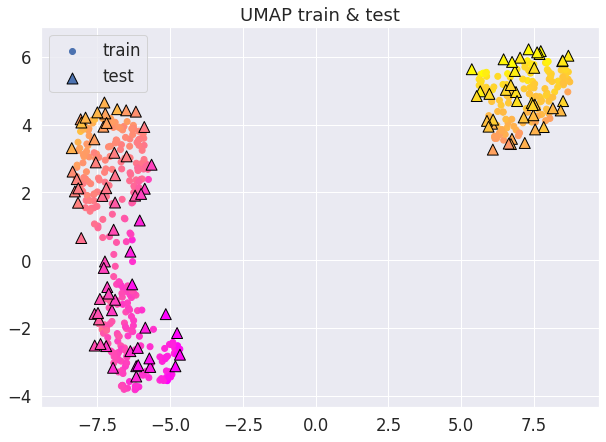

In [10]:
plt.figure(figsize=(10, 7))
plt.scatter(X_umap_train[:, 0], X_umap_train[:, 1],
            c=colors_train, label='train', cmap='spring')
plt.scatter(X_umap_test[:, 0], X_umap_test[:, 1], s=120,
            c=colors_test, label='test', marker='^', 
            edgecolors='black', cmap='spring')
plt.legend()
plt.title('UMAP train & test');

## Сравнение времени работы

Сгенерируем больший размер данных

In [11]:
n_samples = 10000
X = np.zeros((n_samples, 10))

X[:, :2], y = make_blobs(n_samples=n_samples, n_features=2)
X[:, 2:] = sps.norm(0, 0.2).rvs((n_samples, 8))

In [12]:
%timeit UMAP(n_components=2).fit_transform(X)

17.4 s ± 723 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
%timeit MulticoreTSNE(n_components=2).fit_transform(X)

1min 6s ± 3.96 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


Реализация t-SNE из sklearn

In [14]:
%timeit TSNE(n_components=2).fit_transform(X)

1min 17s ± 4.74 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


## UMAP на высокоразмерных данных
UMAP в отличие от TSNE эффективно справляется с данными с большой размерностью. 

Датасет &mdash; MNIST, черно-белые изображения цифр. Размерность объекта: 28*28 = 784 .

In [15]:
X_mnist = np.loadtxt('../5/train.txt')
labels_mnist = np.loadtxt('../5/train_labels.txt')

Визуализация изображений цифр

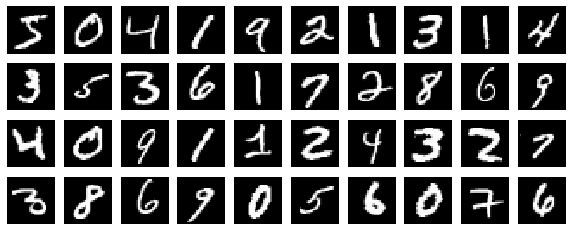

In [16]:
plt.figure(figsize=(10, 4))
for i in range(40):
    plt.subplot(4, 10, i + 1)
    plt.imshow(X_mnist[i].reshape((28, 28)), cmap='gray')
    plt.axis('off')

Разбиение на train и test

In [17]:
X_mnist_train, X_mnist_test, labels_mnist_train, labels_mnist_test \
    = train_test_split(X_mnist, labels_mnist, test_size=50)

Обучаем UMAP на высокоразмерных данных **без** предварительного использования PCA и применяем к тестовой выборке

In [18]:
%%time

umap = UMAP(n_components=2)
umap.fit(X_mnist_train)
X_mnist_umap_train = umap.transform(X_mnist_train)
X_mnist_umap_test = umap.transform(X_mnist_test)

CPU times: user 1min 14s, sys: 1.94 s, total: 1min 16s
Wall time: 1min 7s


Визуализация результатов

Text(0.5, 1.0, 'UMAP MNIST - обучение и тест')

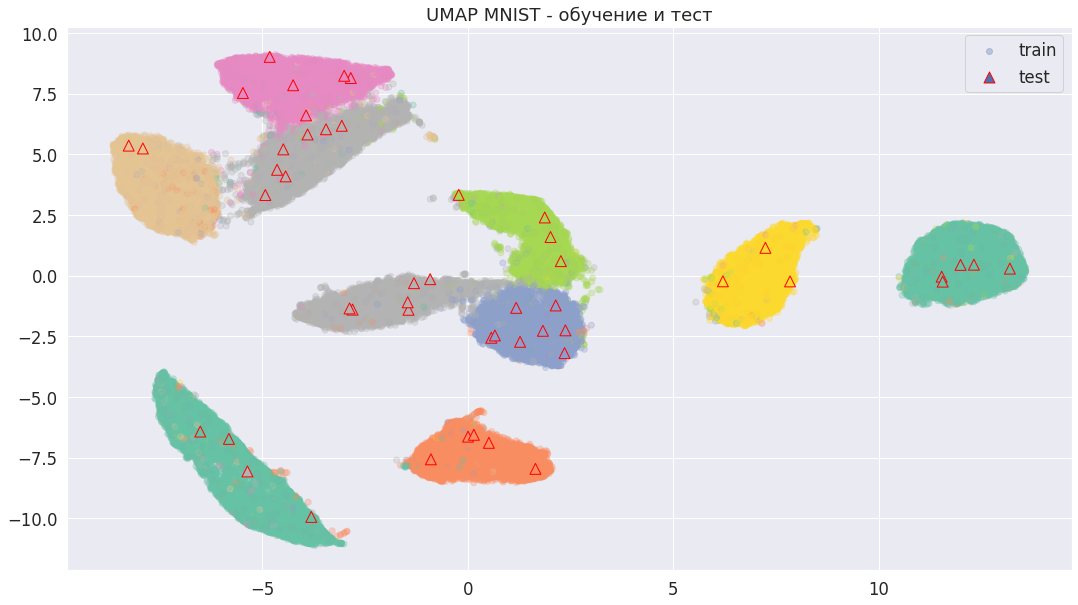

In [19]:
plt.figure(figsize=(18, 10))
plt.scatter(
    X_mnist_umap_train[:, 0], X_mnist_umap_train[:, 1],
    c=labels_mnist_train, label='train', cmap='Set2', alpha=0.3
)
plt.scatter(
    X_mnist_umap_test[:, 0], X_mnist_umap_test[:, 1], s=120,
    c=labels_mnist_test, label='test', marker='^', 
    edgecolors='red', cmap='Set2'
)
plt.legend()
plt.title('UMAP MNIST - обучение и тест')

## UMAP на категориальных признаках  

Загрузим данные

https://github.com/datasets/openml-datasets/blob/master/data/kr-vs-kp/kr-vs-kp.csv

Данные состоят некоторого количества бинарных переменных, которые задают комбинацию в игре, а так же результата игры с такой позицией. 

In [20]:
kr_vs_kp = pd.read_csv('kr-vs-kp.csv')
kr_vs_kp.head()

,bkblk,bknwy,bkon8,bkona,bkspr,bkxbq,bkxcr,bkxwp,blxwp,bxqsq,...,spcop,stlmt,thrsk,wkcti,wkna8,wknck,wkovl,wkpos,wtoeg,class
0,'f','f','f','f','f','f','f','f','f','f',...,'f','f','f','f','f','f','t','t','n','won'
1,'f','f','f','f','t','f','f','f','f','f',...,'f','f','f','f','f','f','t','t','n','won'
2,'f','f','f','f','t','f','t','f','f','f',...,'f','f','f','f','f','f','t','t','n','won'
3,'f','f','f','f','f','f','f','f','t','f',...,'f','f','f','f','f','f','t','t','n','won'
4,'f','f','f','f','f','f','f','f','f','f',...,'f','f','f','f','f','f','t','t','n','won'


Размер данных

In [21]:
kr_vs_kp.shape

(3196, 37)

Все признаки бинарны, переведем их в целочисленный тип данных

In [22]:
X = (kr_vs_kp.iloc[:, :-2] == "'t'").astype(int)

Обучаем UMAP, ипользуя <a href="https://ru.wikipedia.org/wiki/Коэффициент_Жаккара">меру Жаккара</a>. С помощью параметра `min_dist` увеличиваем также минимальное расстояние между точками в новом пространстве равным 1 (вместо 0.1 по умлчанию). Это позволяет распологать точки более разреженно.

In [23]:
X_umap = UMAP(n_components=2, metric='jaccard', min_dist=1).fit_transform(X)

Визуализация результата. Цвет точки означает тип комбинации (выигрышная или проигрышная).

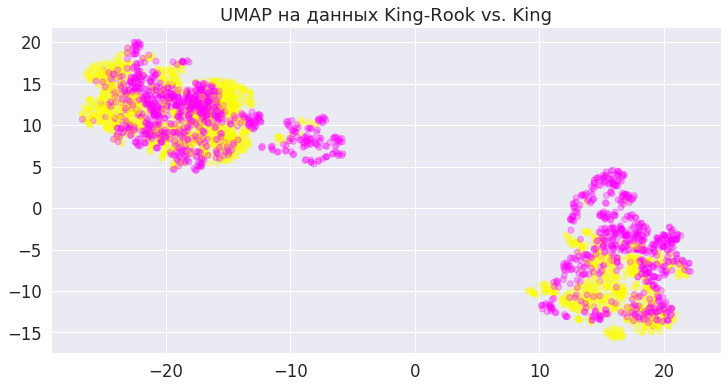

In [24]:
plt.figure(figsize=(12, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=kr_vs_kp.iloc[:, -1]=="'won'", 
            cmap='spring', alpha=0.3)
plt.title('UMAP на данных King-Rook vs. King');

## UMAP на данных c вещественными и категориальными признаками  
C помощью подбора правильной метрики, можно работать с категориальными признаками.

Датасет &mdash; ранее используемый датасет с искуственными данными, но теперь последний признак будет бинарным. Можно рассматривать и большее количество признаков, но небинарные нужно предварительно бинаризировать.

In [26]:
# Генерация данных
n_samples = 1000
X = np.zeros((n_samples, 10))

X[:, :2], y = make_blobs(
    n_samples=n_samples, n_features=2, 
    # параметры 3 кластеров
    centers=[[0, 0], [2, -0.5], [1.5, 3]],
    cluster_std=[0.5, 0.5, 0.5],
)

X[:, 2:-1] = sps.norm(0, 0.2).rvs((n_samples, 7))

Создаем бинарный признак

In [27]:
from scipy.special import expit
X[:, -1] = sps.bernoulli(p=expit(-3*X[:, 0] + 2*X[:, 1])).rvs(size=n_samples)

Визуализируем первые два признака и бинарный (формой точки)

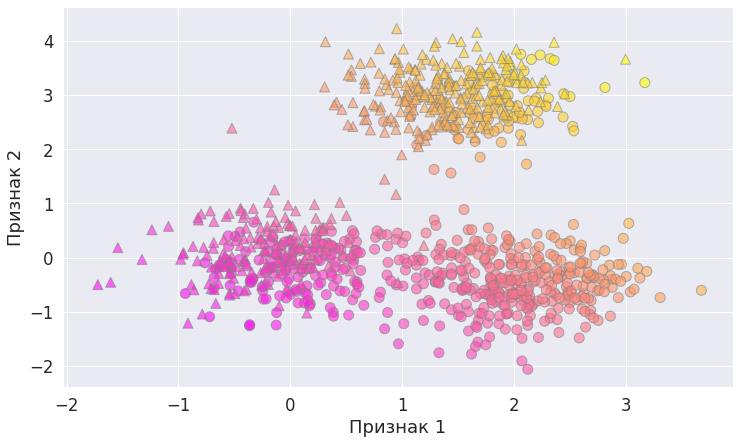

In [29]:
plt.figure(figsize=(12, 7))

colors = 3*X.T[0] + 2*X.T[1]
for k, marker in zip([0, 1], ['o', '^']):
    mask = X[:, -1] == k
    plt.scatter(X[mask, 0], X[mask, 1], c=colors[mask], cmap='spring', 
                marker=marker, edgecolors='gray', s=100, alpha=0.6)

plt.xlabel('Признак 1'), plt.ylabel('Признак 2');

О проблеме UMAP с категориальными признаками написано в этом посте

https://github.com/lmcinnes/umap/issues/58

В качестве решения проблемы предлагается следующий код

In [30]:
# Обучение на вещественных признаках
fit1 = UMAP().fit(X[:, [0, 1, 2, 3, 4, 5, 6, 7, 8]])
# Обучение на бинарных признаках
# c использованием метрики jaccard
fit2 = UMAP(metric='jaccard').fit(X[:, [9]])

# Пересечение графов многообразий
intersection = umap_.general_simplicial_set_intersection(
    fit1.graph_, fit2.graph_, weight=0.5)
# Обновление весов в новом графе
intersection = umap_.reset_local_connectivity(intersection)

# Новое представление данных,
# в качестве графа используется новыый граф,
# все остальные параметры те же, что и для графа с вещ. признаками
embedding = umap_.simplicial_set_embedding(
    fit1._raw_data, intersection, fit1.n_components, 
    fit1._initial_alpha, fit1._a, fit1._b, 
    fit1.repulsion_strength, fit1.negative_sample_rate, 
    200, 'random', np.random, fit1.metric, 
    fit1._metric_kwds, False
)

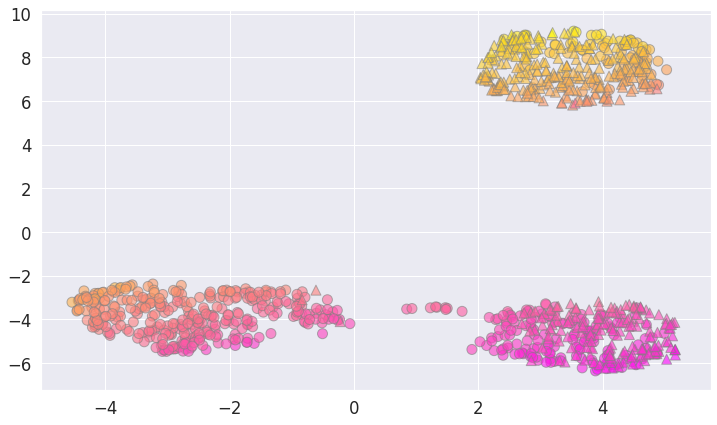

In [31]:
plt.figure(figsize=(12, 7))

for k, marker in zip([0, 1], ['o', '^']):
    mask = X[:, -1] == k
    plt.scatter(embedding[mask, 0], embedding[mask, 1], c=colors[mask], 
                cmap='spring', marker=marker, edgecolors='gray', 
                s=100, alpha=0.6)

## UMAP на разреженных данных
Идея примера взята [отсюда](https://umap-learn.readthedocs.io/en/latest/sparse.html).  
Датасет &mdash; натуральные числа, представленные в виде вектора из составляющих данное число простых числел.

Возьмем все простые числа от 2 до 110000 и присвоим каждому их них номер (индекс).

In [32]:
primes = list(sympy.primerange(2, 110000))
prime_to_column = {p:i for i, p in enumerate(primes)}

Количество простых чисел в этом диапазоне

In [33]:
len(primes)

10453

Все числа от 0 до 100000 разложим на простые. Будем записывать только факт деления числа на простое без сохранения степени

In [34]:
%%time

# Представленеие данных в формате LIL - list to list
lil_matrix_rows = []
lil_matrix_data = []

for n in range(100000):
    # простые множители, входящие в число n
    prime_factors = sympy.primefactors(n)
    lil_matrix_rows.append([prime_to_column[p] for p in prime_factors])
    lil_matrix_data.append([1] * len(prime_factors))

CPU times: user 1.74 s, sys: 0 ns, total: 1.74 s
Wall time: 1.74 s


Индексы простых чисел, на которые делятся числа от 0 до 10

In [35]:
lil_matrix_rows[:11]

[[], [], [0], [1], [0], [2], [0, 1], [3], [0], [1], [0, 2]]

Степень простого числа не сохраняем:

In [36]:
lil_matrix_data[:11]

[[], [], [1], [1], [1], [1], [1, 1], [1], [1], [1], [1, 1]]

Составляем разреженную матрицу. Такая матрица хранится в виде списка `(i, j) -> value`. Хранение данных в виде полной матрицы проблематично, а зачастую на практике невозможно вовсе.

In [37]:
factor_matrix = sparse.lil_matrix(
    (len(lil_matrix_rows), len(primes)),
    dtype=np.float32
)

factor_matrix.rows = np.array(lil_matrix_rows)
factor_matrix.data = np.array(lil_matrix_data)

Обучаем UMAP, используя <a href="https://en.wikipedia.org/wiki/Cosine_similarity">косинусную метрику</a>.

In [38]:
%%time
mapper = UMAP(metric='cosine')
data_embedding = mapper.fit_transform(factor_matrix)

CPU times: user 6min 5s, sys: 8.81 s, total: 6min 14s
Wall time: 5min 28s


Визуализация

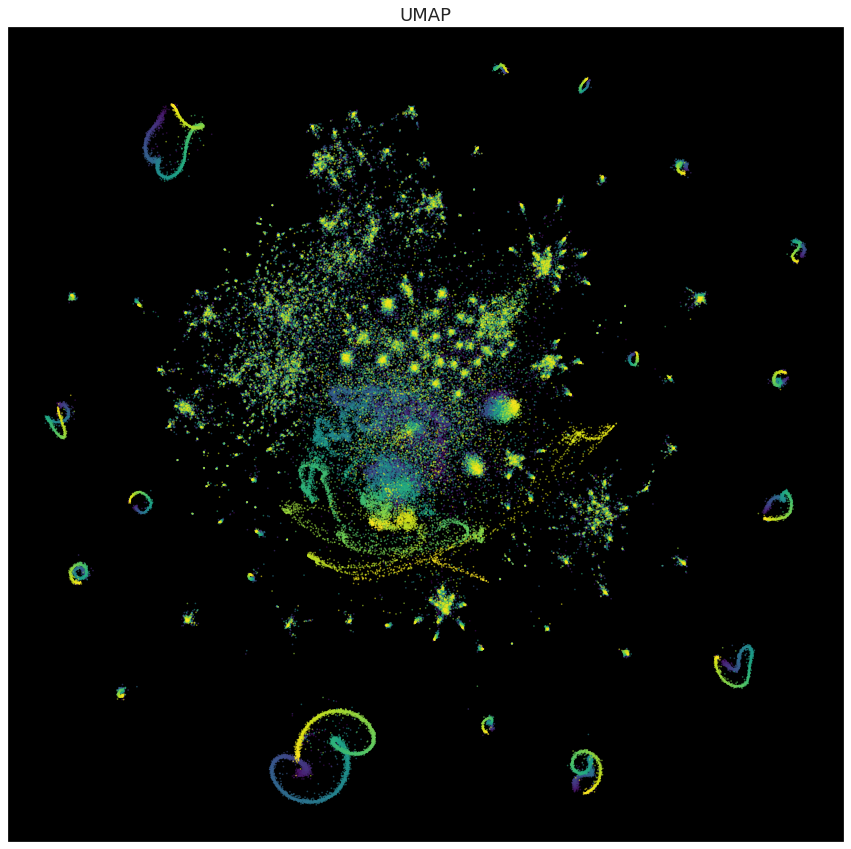

In [39]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111)
plt.scatter(data_embedding[:, 0], data_embedding[:, 1], c=range(100000), 
            cmap='viridis', s=0.5, alpha=0.5)
plt.title('UMAP')
ax.set(xticks=[], yticks=[], facecolor='black');

Разложим следующие чила на простые множители

In [40]:
%%time

lil_matrix_rows = []
lil_matrix_data = []

for n in range(100000, 110000):
    prime_factors = sympy.primefactors(n)
    lil_matrix_rows.append([prime_to_column[p] for p in prime_factors])
    lil_matrix_data.append([1] * len(prime_factors))

CPU times: user 210 ms, sys: 0 ns, total: 210 ms
Wall time: 210 ms


Создадим из них разреженную матрицу

In [41]:
new_data = sparse.lil_matrix((len(lil_matrix_rows), len(primes)), 
                             dtype=np.float32)
new_data.rows = np.array(lil_matrix_rows)
new_data.data = np.array(lil_matrix_data)
new_data

<10000x10453 sparse matrix of type '<class 'numpy.float32'>'
	with 27592 stored elements in LInked List format>

Переводим их в сжатое пространство и...

In [42]:
new_data_embedding = mapper.transform(new_data)

ValueError: Transform not available for sparse input.

Хотя на сайте в нестабильной версии все есть. Ну не доработали еще разработчики UMAP. Бывает. Подождем...